In [21]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib import pyplot
from pylab import rcParams
import pickle as pk
import gc
import requests 
import matplotlib.gridspec as gridspec
import netCDF4 as nc
import hvplot
import hvplot.pandas
import hvplot.xarray
import holoviews as hv
from holoviews import opts

In [22]:
from IPython.display import Image
Image(url = "https://cdn-images-1.medium.com/max/800/1*w-05-YnuJMl84KMSRw1J2g.png")

Covariance is scale-dependent. 

#### Pearson's Corellation Coefficient

In [23]:
def mean(x):
    return sum(x)/len(x)

def covariance(x,y):
    calc = []
    for i in range(len(x)):
        xi = x[i] - mean(x)
        yi = y[i] - mean(y)
        calc.append(xi * yi)
    return sum(calc)/(len(x) - 1)
    
a = [1,2,3,4,5] ; b = [5,4,3,2,1]
print(covariance(a,b))

-2.5


#### Normalizing covariance

In [24]:
import math

def stDev(x):
    variance = 0
    for i in x:
        variance += (i - mean(x) ** 2) / len(x)
    return math.sqrt(variance)
    
def Pearsons(x,y):
    cov = covariance(x,y)
    return cov / (stDev(x) * stDev(y))

#### Import Seismic Data 

In [25]:
seismic_file = '/home/jovyan/data/hypo71.dat.txt'
df_seismic_data = pd.read_csv(seismic_file, delim_whitespace=True, dtype=object)
df_seismic_data['datetime'] = df_seismic_data['yyyymmdd'] + 'T' + \
            df_seismic_data['HHMM'].str.slice(start=0, stop=2) + ':' + \
            df_seismic_data['HHMM'].str.slice(start=2) 
df_seismic_data.index = pd.to_datetime(df_seismic_data['datetime'].values)
df_seismic_data['datetime'] = pd.to_datetime(df_seismic_data['datetime'].values)
df_seismic_data = df_seismic_data.loc['2017-01-1 00:00:00':'2019-06-17 00:00:00']
df_seismic_data.head()
# del df_seismic_data['yyyymmdd']
# del df_seismic_data['HHMM']
del df_seismic_data['Lon(D']
# del df_seismic_data['SSS.SS']
# del df_seismic_data['Depth']
del df_seismic_data['M)']
del df_seismic_data['M).1']
del df_seismic_data['NWR']
del df_seismic_data['GAP']
del df_seismic_data['DMIN']
del df_seismic_data['ERH']
del df_seismic_data['ERZ']
del df_seismic_data['ID']
del df_seismic_data['Lat(D']
del df_seismic_data['PMom']
del df_seismic_data['SMom']
df_seismic_data['Depth'] = df_seismic_data['Depth'].astype('float64').values
df_seismic_data['MW'] = df_seismic_data['MW'].astype('float64').values
df_seismic_data['RMS'] = df_seismic_data['RMS'].astype('float64').values

In [26]:
df_seismic_data.datetime.astype(np.int64).values/1e64
df_seismic_data['date'] =pd.DatetimeIndex(df_seismic_data.datetime).date
df_seismic_data.tail()

,yyyymmdd,HHMM,SSS.SS,Depth,MW,RMS,datetime,date
2019-06-13 22:51:00,20190613,2251,38.04,1.58,0.65,0.02,2019-06-13 22:51:00,2019-06-13
2019-06-14 08:06:00,20190614,0806,0.73,0.61,0.34,0.04,2019-06-14 08:06:00,2019-06-14
2019-06-14 14:34:00,20190614,1434,18.36,0.70,0.25,0.01,2019-06-14 14:34:00,2019-06-14
2019-06-14 22:26:00,20190614,2226,27.48,0.83,0.34,0.01,2019-06-14 22:26:00,2019-06-14
2019-06-16 16:45:00,20190616,1645,2.57,1.48,0.62,0.04,2019-06-16 16:45:00,2019-06-16


### MW Average

In [27]:
# values = make_array(2, 3, 3, 9)
# MW = make_array(df_seismic_data['MW'])
mw = df_seismic_data['MW']
depth = df_seismic_data['Depth']
average = mw.mean(), depth.mean()
mw_average = mw.mean()
depth_average = depth.mean()
# mw_average
average

(0.6170656145739554, 1.1020784791357765)

### MW Histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e144d9710>]],
      dtype=object)

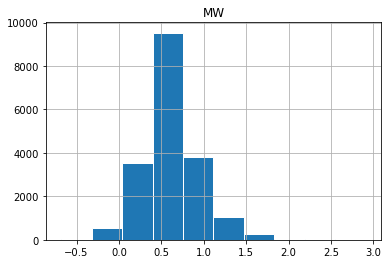

In [28]:
df_seismic_data.hist('MW', ec='w')
# df_seismis_data.hist('MW', bins=np.arange(65.5, 90.5), ec='w')
# nba.hist('Height', bins=np.arange(65.5, 90.5), ec='w')

In [29]:
deviations_mw = mw - mw_average
deviations_depth = depth - depth_average
df_seismic_data['MW Dev'] = deviations_mw
df_seismic_data['Depth Dev'] = deviations_depth
df_seismic_data.head(5)

,yyyymmdd,HHMM,SSS.SS,Depth,MW,RMS,datetime,date,MW Dev,Depth Dev
2017-01-01 02:15:00,20170101,0215,31.68,0.51,0.13,0.02,2017-01-01 02:15:00,2017-01-01,-0.487066,-0.592078
2017-01-01 02:36:00,20170101,0236,35.66,1.09,-0.02,0.01,2017-01-01 02:36:00,2017-01-01,-0.637066,-0.012078
2017-01-01 05:31:00,20170101,0531,15.63,0.93,0.06,0.02,2017-01-01 05:31:00,2017-01-01,-0.557066,-0.172078
2017-01-02 17:11:00,20170102,1711,2.71,0.56,-0.03,0.03,2017-01-02 17:11:00,2017-01-02,-0.647066,-0.542078
2017-01-04 01:48:00,20170104,0148,37.13,1.57,0.71,0.02,2017-01-04 01:48:00,2017-01-04,0.092934,0.467922


In [30]:
# Sum of deviations should equal to zero
deviations_mw.sum()

8.952838470577262e-13

In [31]:
sqdev_mw = deviations_mw ** 2
df_seismic_data['MW Squared Deviation'] = sqdev_mw
df_seismic_data.head(5)

,yyyymmdd,HHMM,SSS.SS,Depth,MW,RMS,datetime,date,MW Dev,Depth Dev,MW Squared Deviation
2017-01-01 02:15:00,20170101,0215,31.68,0.51,0.13,0.02,2017-01-01 02:15:00,2017-01-01,-0.487066,-0.592078,0.237233
2017-01-01 02:36:00,20170101,0236,35.66,1.09,-0.02,0.01,2017-01-01 02:36:00,2017-01-01,-0.637066,-0.012078,0.405853
2017-01-01 05:31:00,20170101,0531,15.63,0.93,0.06,0.02,2017-01-01 05:31:00,2017-01-01,-0.557066,-0.172078,0.310322
2017-01-02 17:11:00,20170102,1711,2.71,0.56,-0.03,0.03,2017-01-02 17:11:00,2017-01-02,-0.647066,-0.542078,0.418694
2017-01-04 01:48:00,20170104,0148,37.13,1.57,0.71,0.02,2017-01-04 01:48:00,2017-01-04,0.092934,0.467922,0.008637


#### MW Variance

In [32]:
# Variance of the data is the average of the squared deviations
variance_mw = sqdev_mw.mean()
variance_mw

0.11312732646843948

#### MW STDEV

In [33]:
# Standard Deviation (SD) is the square root of the variance

sd_mw = variance_mw ** 0.5
sd_mw

0.3363440596598065

#### Depth vs MW

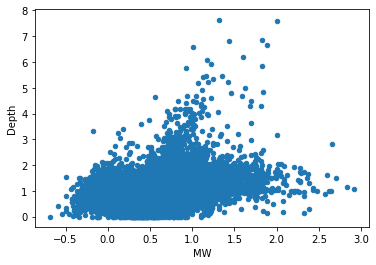

In [34]:
ax1 = df_seismic_data.plot.scatter(x='MW',
                                  y='Depth')
plt.savefig('/home/jovyan/botpt/figures/mwvsdepth.png')

In [38]:
df_eqMean=df_seismic_data.groupby('date').mean()
df_eqCount= df_seismic_data.groupby('date').count()
#del df_eqMean['datetime']
#df_eqMean.columns.name = df_eqMean.index.name
#df_eqMean.index.name = None
df_eqMean.tail()

,Depth,MW,RMS,MW Dev,Depth Dev,MW Squared Deviation
date,,,,,,
2019-06-11,1.667500,0.53,0.0225,-0.087066,0.565422,0.014430
2019-06-12,1.200000,0.63,0.0200,0.012934,0.097922,0.000167
2019-06-13,1.580000,0.65,0.0200,0.032934,0.477922,0.001085
2019-06-14,0.713333,0.31,0.0200,-0.307066,-0.388745,0.096089
2019-06-16,1.480000,0.62,0.0400,0.002934,0.377922,0.000009


In [39]:
# df_seismic_data['count'] = df_eqCount.datetime.astype('float64').values
# df_seismic_data.head()
df_eqCount['count'] = df_eqCount.datetime.astype('float64').values
df_eqCount.head()

,yyyymmdd,HHMM,SSS.SS,Depth,MW,RMS,datetime,MW Dev,Depth Dev,MW Squared Deviation,count
date,,,,,,,,,,,
2017-01-01,3,3,3,3,3,3,3,3,3,3,3.0
2017-01-02,1,1,1,1,1,1,1,1,1,1,1.0
2017-01-04,6,6,6,6,6,6,6,6,6,6,6.0
2017-01-05,2,2,2,2,2,2,2,2,2,2,2.0
2017-01-06,4,4,4,4,4,4,4,4,4,4,4.0


In [43]:
df_eqMean['count'] = df_eqCount['count'].values
df_eqMean.head()

,Depth,MW,RMS,MW Dev,Depth Dev,MW Squared Deviation,count
date,,,,,,,
2017-01-01,0.843333,0.056667,0.016667,-0.560399,-0.258745,0.317803,3.0
2017-01-02,0.560000,-0.030000,0.030000,-0.647066,-0.542078,0.418694,1.0
2017-01-04,1.281667,0.308333,0.030000,-0.308732,0.179588,0.162430,6.0
2017-01-05,1.390000,0.540000,0.035000,-0.077066,0.287922,0.090039,2.0
2017-01-06,1.422500,0.052500,0.027500,-0.564566,0.320422,0.342053,4.0


#### Daily Average MW vs Depth

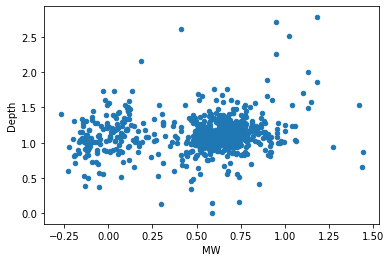

In [46]:
ax1 = df_eqMean.plot.scatter(x='MW',
                                  y='Depth')
plt.savefig('/home/jovyan/botpt/figures/mwvsdepth.png')

#### Depth vs Count

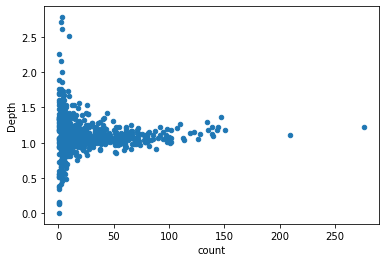

In [47]:
ax2 = df_eqMean.plot.scatter(x='count',
                                  y='Depth')
plt.savefig('/home/jovyan/botpt/figures/countvsdepth.png')

#### MW vs Count

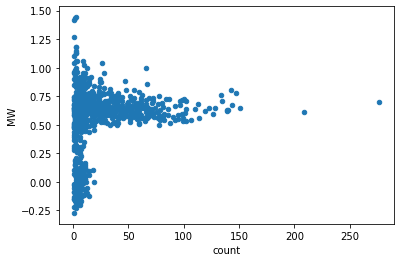

In [48]:
ax3 = df_eqMean.plot.scatter(x='count',
                                  y='MW')
plt.savefig('/home/jovyan/botpt/figures/countvsmw.png')

In [51]:
#MW and Depth Correlation Coeeficient
depth = df_eqMean['Depth']
mw = df_eqMean['MW']

# Next, break into parts to solve
n=len(depth)
sumxy = sum(depth*mw)
sumx = sum(depth)
sumy = sum(mw)
sumx2 = sum(depth**2)
sumy2 = sum(mw**2)

cc = ((n*sumxy) - (sumx*sumy)) / np.sqrt( ((n*sumx2) - sumx**2) * ((n*sumy2) - sumy**2) )
# Print the correlation coefficient:
print('CC = %0.3f' % cc)

CC = 0.130


In [54]:
#Depth and Depth Correlation Coeeficient
depth = df_eqMean['Depth']
count = df_eqMean['count']
# mw = df_eqMean['MW']


# Next, break into parts to solve
# n=len(depth)
sumxz = sum(depth*count)
sumx = sum(depth)
sumz = sum(count)
sumx2 = sum(depth**2)
sumz2 = sum(count**2)

cc = ((n*sumxz) - (sumx*sumz)) / np.sqrt( ((n*sumx2) - sumx**2) * ((n*sumz2) - sumz**2) )
# Print the correlation coefficient:
print('CC = %0.3f' % cc)

CC = -0.016


In [55]:
# MW and Count Correlation Coefficient
mw = df_eqMean['MW']
count = df_eqMean['count']
# mw = df_eqMean['MW']


# Next, break into parts to solve
# n=len(depth)
sumyz = sum(mw*count)
sumy = sum(mw)
sumz = sum(count)
sumy2 = sum(mw**2)
sumz2 = sum(count**2)

cc = ((n*sumyz) - (sumy*sumz)) / np.sqrt( ((n*sumy2) - sumy**2) * ((n*sumz2) - sumz**2) )
# Print the correlation coefficient:
print('CC = %0.3f' % cc)

CC = 0.239


In [5]:
# Plot Regression Lines and Calculate R Squared Value 

In [1]:
# Inflation vs Count

In [3]:
# Inflation vs Depth

In [4]:
# Inflation vs MW

In [ ]:
# Relative inflation vs Count 
# relative to highest prior value

how fast vs where are we comapared to prior high

#### Regression Model

In [39]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x)) / np.std(x)

def correlation(t, x, y):
    """Return the correlation coefficient (r) of two variables."""
    return np.mean(standard_units(t.column(x)) * standard_units(t.column(y)))

def slope(t, x, y):
    """The slope of the regression line (original units)."""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)."""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

def fit(t, x, y):
    """The fitted values along the regression line."""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a * t.column(x) + b

def plot_residuals(t, x, y):
    """Plot a scatter diagram and residuals."""
    t.scatter(x, y, fit_line=True)
    actual = t.column(y)
    fitted = fit(t, x, y)
    residuals = actual - fitted
    print('r:', correlation(t, x, y))
    print('RMSE:', np.mean(residuals**2)**0.5)
    t.select(x).with_column('Residual', residuals).scatter(0, 1)

### Calculating R